In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objectives

Course4U grows rapidly and reaches millions of learners in a very short period. The learning topics of AI Training Room can be summarized in the following word cloud:
​
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_1/images/word_cloud.png" width="600" alt="word cloud">
<center>

Starting this year, machine learning engineer team is working very hard on a recommender system project. **The main goal of this project is to improve learners’ learning experience via helping them quickly find new interested courses and better paving their learning paths**. Meanwhile, **with more learners interacting with more courses via C4U recommender systems,C4U company’s revenue may also be increased**.

This project is currently at the *Proof of Concept (PoC) phase* so your **main focus at this moment is to explore and compare various machine learning models and find one with the best performance in off-line evaluations.**

In <a href="https://www.kaggle.com/code/wahyuardhitama/task003-p001-ml-dl-rec-sys-course-20231025">Part 1 (P01)</a>, we elaborate on a content-based recommender system using unsupervised learning, where we utilize user profiles and course genres. In part 2 (P02), we explore clustering-based recommender system using unsupervised learning. Finally, in the last part,<a href="https://www.kaggle.com/wahyuardhitama/task003-p003-ml-dl-rec-sys-course-20231101"> part 3 (P03)</a>, we take a deep dive into a content-based recommender system using supervised learning.

### Note: 
This project's dataset was created for pedagogical purposes and may not represent real-world data. The project consists of multiple notebook parts, focusing on combining data from various tables and conducting data analysis and prediction to acquire valuable insights.

## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Import">Import the relevant libraries</a></li>
    <li><a href="#Tit_1">Clustering based Course Recommender System</a></li>
    <ol>
        <li><a href="#KM_1">Perform K-means clustering algorithm on the user profile feature vectors</a></li>
        <li><a href="#App_1">Apply PCA on user profile feature vectors to reduce dimensions</a></li>
        <li><a href="#App_2">Perform k-means clustering on the PCA transformed feature vectors</a></li>
    </ol>
    <li><a href="#Gen_1">Generate course recommendations based on the popular courses in the same cluster</a></li>
</ol>

<img style="float:left" src="https://i.imgur.com/gIne5bH.png" width="80">

<h1><a id="Import">Import the Relevant Libraries</a></h1>

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Sets backend to render higher res images
sns.set_style("whitegrid")
sns.set_context("notebook")

%matplotlib inline

In [3]:
# also set a random state
rs = 123

<h1><a id="Tit_1">Clustering based Course Recommender System</a></h1>

In [4]:
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
user_profile_df = pd.read_csv(user_profile_url)
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


<img style="float:left" src="https://i.imgur.com/rb8V6X5.png" width="50">

# Explarotary Data Analysis (EDA)

In [5]:
user_profile_df.shape

(33901, 15)

In [6]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

About 33K unique users with interests in areas like Database, Python, CloudComputing, etc. 

In [7]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,5.518569,3.493791,2.307100,3.624701,0.998938,3.048022,0.001770,5.087343,4.750450,0.462995,1.017433,2.269461,0.315802,0.986844
std,4.972578e+05,7.611941,4.227254,3.841858,4.760135,2.351764,4.624004,0.072846,5.230697,7.216228,1.055186,2.342532,4.310752,1.363462,1.950585
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,3.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,9.000000,6.000000,3.000000,6.000000,0.000000,3.000000,0.000000,9.000000,6.000000,0.000000,0.000000,3.000000,0.000000,2.000000
max,2.103039e+06,63.000000,18.000000,38.000000,48.000000,15.000000,39.000000,3.000000,32.000000,54.000000,6.000000,18.000000,54.000000,15.000000,12.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.

In [8]:
profiles = user_profile_df.groupby(['user']).max().reset_index(drop=False)
user_profiles_ids = user_profile_df['user'].to_list()
print(f"Total numbers of user profiles {len(user_profiles_ids)}")

Total numbers of user profiles 33901


In [9]:
user_profiles = user_profile_df.groupby(['user']).max().reset_index(drop=False)
user_profiles_ids = user_profile_df['user'].to_list()
print(f"Total numbers of user profiles {len(user_profiles_ids)}")

Total numbers of user profiles 33901


In [10]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print("mean {} and standard deviation{} ".format(user_profile_df[feature_names].mean(),user_profile_df[feature_names].std()))

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


The normalized user profile features are:

In [11]:
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


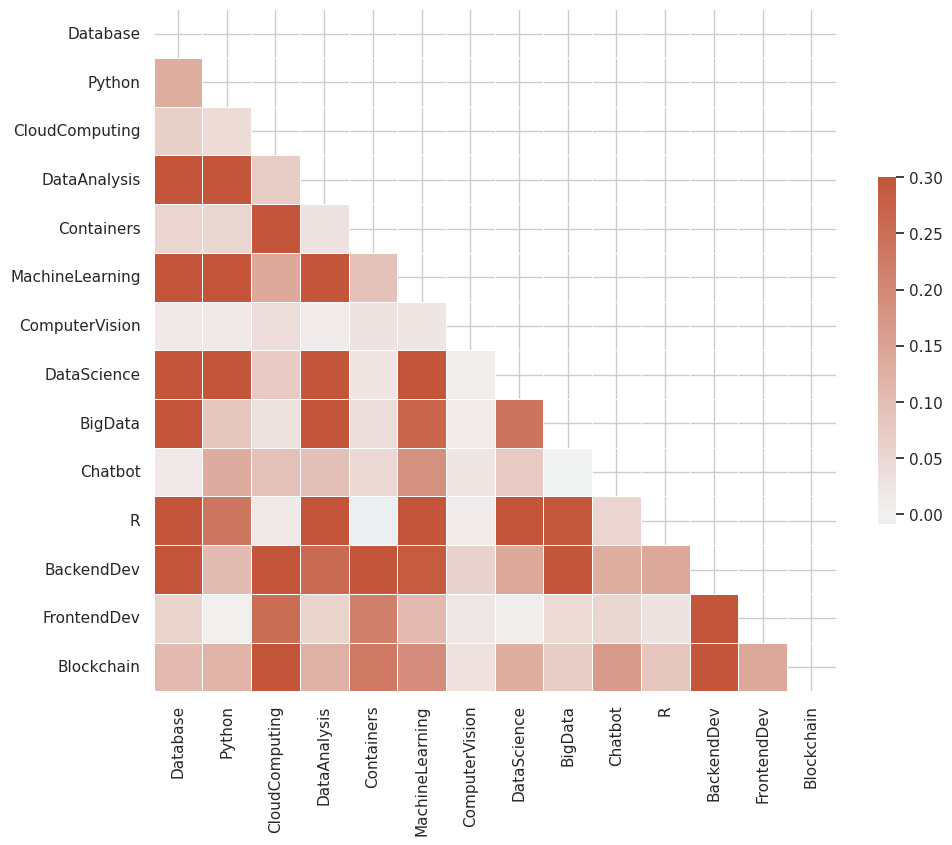

In [12]:
# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [13]:
corr

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
Database,1.000029,0.132192,0.062918,0.614735,0.055417,0.300917,0.016379,0.313317,0.965347,0.017312,0.352335,0.352589,0.059113,0.105320
Python,0.132192,1.000029,0.044384,0.584846,0.050601,0.551221,0.016992,0.566498,0.081800,0.135082,0.235835,0.101671,0.003452,0.120726
CloudComputing,0.062918,0.044384,1.000029,0.068843,0.727078,0.140355,0.037901,0.075063,0.028634,0.090653,0.016437,0.539283,0.253500,0.391726
DataAnalysis,0.614735,0.584846,0.068843,1.000029,0.027014,0.551162,0.011359,0.570076,0.579760,0.095359,0.521579,0.257591,0.058705,0.123524
Containers,0.055417,0.050601,0.727078,0.027014,1.000029,0.090069,0.026873,0.026070,0.038773,0.047308,-0.008082,0.485203,0.220568,0.230896
MachineLearning,0.300917,0.551221,0.140355,0.551162,0.090069,1.000029,0.023131,0.521636,0.266517,0.184125,0.418793,0.287412,0.105164,0.191496
ComputerVision,0.016379,0.016992,0.037901,0.011359,0.026873,0.023131,1.000029,0.008420,0.013298,0.025030,0.011229,0.060764,0.021103,0.032550
DataScience,0.313317,0.566498,0.075063,0.570076,0.026070,0.521636,0.008420,1.000029,0.239182,0.076286,0.499576,0.140273,0.009468,0.133686
BigData,0.965347,0.081800,0.028634,0.579760,0.038773,0.266517,0.013298,0.239182,1.000029,-0.001813,0.293122,0.308203,0.046123,0.069918
Chatbot,0.017312,0.135082,0.090653,0.095359,0.047308,0.184125,0.025030,0.076286,-0.001813,1.000029,0.056705,0.132038,0.051797,0.166034


we can also save the user ids for later recommendation tasks:

In [14]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h3><a id="KM_1">Perform K-means clustering algorithm on the user profile feature vectors</a></h3>

For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:

In [15]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [16]:
# WRITE YOUR CODE HERE

# Find an optimized number of neighors k from a candidate list such as list_k = list(range(1, 30))
distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    distorsions.append(kmeans.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Elbow curve')

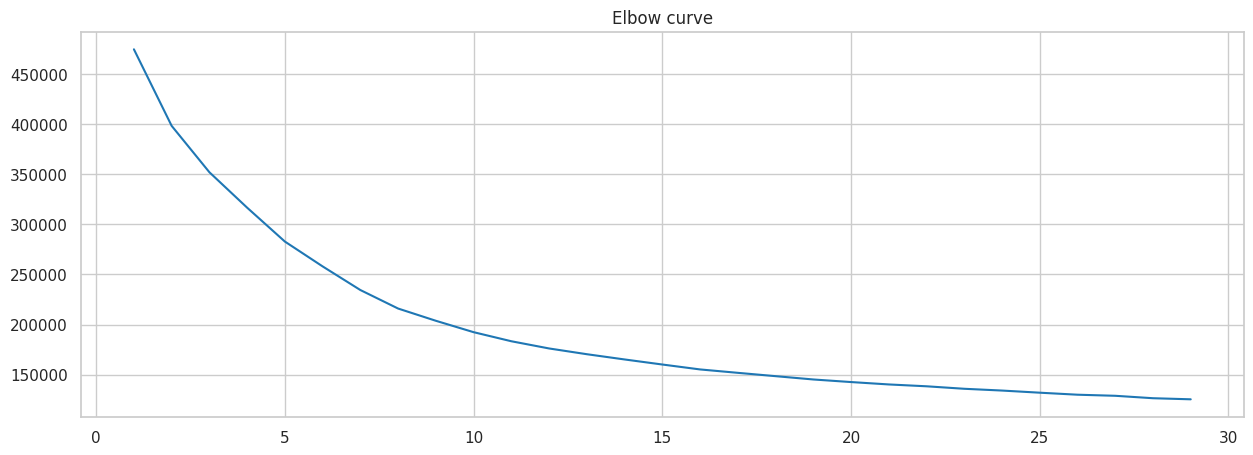

In [17]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [18]:
#cluster_labels = [10] * len(user_ids)
#cluster_labels

In [19]:
cluster_labels = kmeans.labels_
cluster_labels.shape

(33901,)

 The utility method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:

In [20]:
def combine_cluster_labels(user_ids, labels):
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [21]:
combine_cluster_labels(user_ids, cluster_labels)

,user,cluster
0,2,27
1,4,9
2,5,27
3,7,16
4,8,0
...,...,...
33896,2102054,8
33897,2102356,16
33898,2102680,17
33899,2102983,16


In [22]:
cluster_df = combine_cluster_labels(user_ids, cluster_labels)
cluster_df

,user,cluster
0,2,27
1,4,9
2,5,27
3,7,16
4,8,0
...,...,...
33896,2102054,8
33897,2102356,16
33898,2102680,17
33899,2102983,16


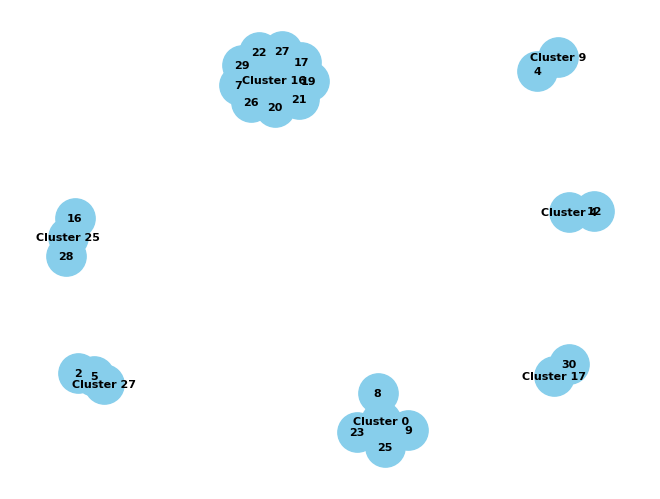

In [23]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes (users) and edges (cluster connections)
for _, row in cluster_df.head(20).iterrows():
    G.add_node(row['user'])
    G.add_edge(row['user'], f'Cluster {row["cluster"]}')

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, font_size=8)
plt.show()

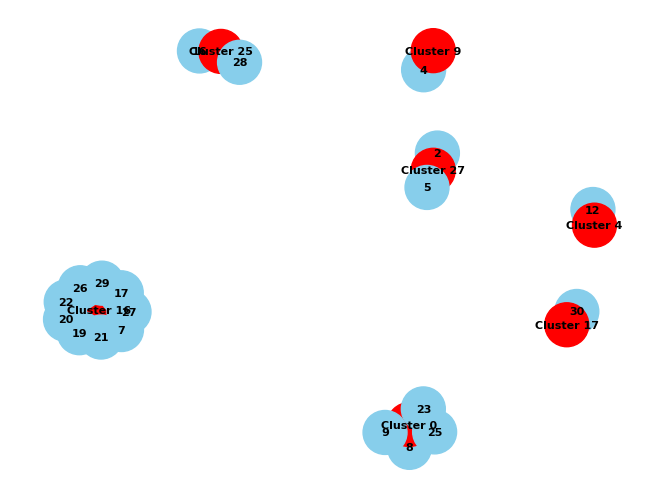

In [24]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes (users) and edges (cluster connections)
for _, row in cluster_df.head(20).iterrows():
    G.add_node(row['user'], node_type='user')  # Assign 'user' as node_type
    G.add_edge(row['user'], f'Cluster {row["cluster"]}')

# Extract node colors based on node type
node_colors = ['skyblue' if 'node_type' in G.nodes[node] and G.nodes[node]['node_type'] == 'user' else 'red' for node in G.nodes]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=1000, font_size=8)

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">
    
Each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.</p> 
</div>

<h3><a id="App_1">Apply PCA on user profile feature vectors to reduce dimensions</a></h3>
Applied KMeans on the original user profile feature vectors which have 14 original features (the course genres).

In [25]:
features_pca = user_profile_df.loc[:, user_profile_df.columns != 'user']
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
feature_names = list(user_profile_df.columns[1:])

In [26]:
features_pca

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


In [27]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


Plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:

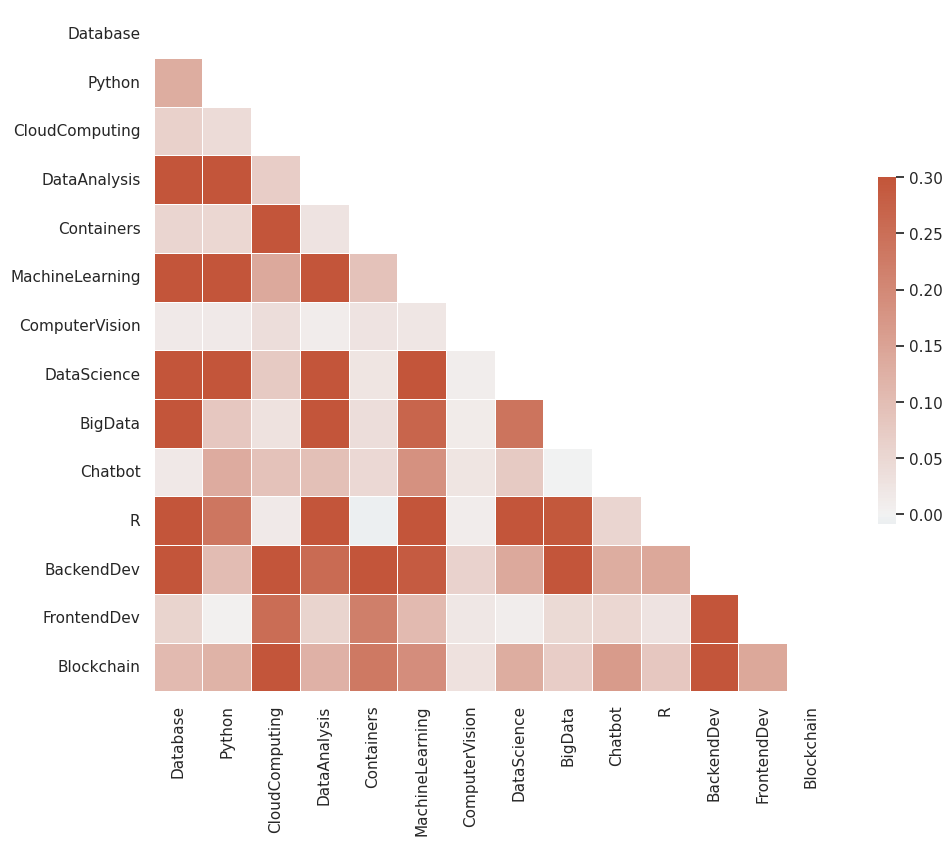

In [28]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr_pca = features_pca.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_pca, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

In [29]:
corr_pca

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
Database,1.000029,0.132192,0.062918,0.614735,0.055417,0.300917,0.016379,0.313317,0.965347,0.017312,0.352335,0.352589,0.059113,0.105320
Python,0.132192,1.000029,0.044384,0.584846,0.050601,0.551221,0.016992,0.566498,0.081800,0.135082,0.235835,0.101671,0.003452,0.120726
CloudComputing,0.062918,0.044384,1.000029,0.068843,0.727078,0.140355,0.037901,0.075063,0.028634,0.090653,0.016437,0.539283,0.253500,0.391726
DataAnalysis,0.614735,0.584846,0.068843,1.000029,0.027014,0.551162,0.011359,0.570076,0.579760,0.095359,0.521579,0.257591,0.058705,0.123524
Containers,0.055417,0.050601,0.727078,0.027014,1.000029,0.090069,0.026873,0.026070,0.038773,0.047308,-0.008082,0.485203,0.220568,0.230896
MachineLearning,0.300917,0.551221,0.140355,0.551162,0.090069,1.000029,0.023131,0.521636,0.266517,0.184125,0.418793,0.287412,0.105164,0.191496
ComputerVision,0.016379,0.016992,0.037901,0.011359,0.026873,0.023131,1.000029,0.008420,0.013298,0.025030,0.011229,0.060764,0.021103,0.032550
DataScience,0.313317,0.566498,0.075063,0.570076,0.026070,0.521636,0.008420,1.000029,0.239182,0.076286,0.499576,0.140273,0.009468,0.133686
BigData,0.965347,0.081800,0.028634,0.579760,0.038773,0.266517,0.013298,0.239182,1.000029,-0.001813,0.293122,0.308203,0.046123,0.069918
Chatbot,0.017312,0.135082,0.090653,0.095359,0.047308,0.184125,0.025030,0.076286,-0.001813,1.000029,0.056705,0.132038,0.051797,0.166034


In [30]:
from sklearn.decomposition import PCA

In [31]:
accVarRatio = []

for n_components in range(1, 15):
    pca = PCA(n_components=n_components)
    pca.fit(features_pca)

    print(pca.explained_variance_ratio_.sum())
    print(pca.singular_values_)

    accVarRatio.append(pca.explained_variance_ratio_.sum())

0.28756843387699726
[369.43741645]
0.463092564474531
[369.43741645 288.62815129]
0.5761339643675626
[369.43741645 288.6281513  231.62692194]
0.6487465627832347
[369.43741645 288.6281513  231.62692194 185.64200975]
0.7194878762997219
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477]
0.7882103410314046
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592]
0.8429558465572842
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997]
0.8944445500368896
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282]
0.9272695591307689
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282 124.81670107]
0.9544658170614707
[369.43741645 288.6281513  231.62692194 185.64200975 183.23432477
 180.60078592 161.19237997 156.32421282 124.81670107 113.61216819]
0.9733572103164779
[369.43741645 288.6281513  231.62692194 185.6420097

Visualize your hyperparameter searching process, you may get a trend line like the following:

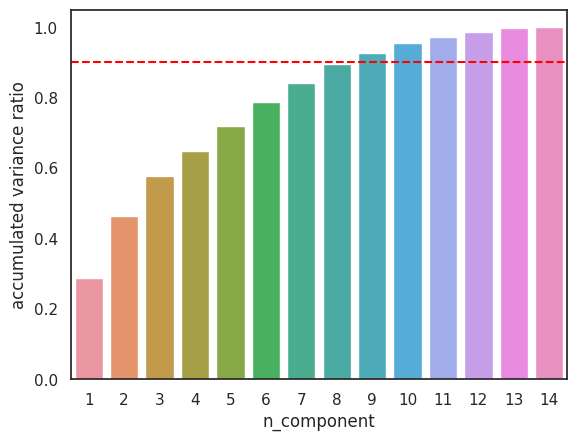

In [32]:
plot_df = pd.DataFrame({'n_component': range(1, 15), 'accumulated variance ratio': accVarRatio})
# Create a bar plot using seaborn
ax = sns.barplot(x='n_component', y='accumulated variance ratio', data=plot_df)

# Add a horizontal line at y=0.9
ax.axhline(y=0.9, color='red', linestyle='--', label='Threshold at 0.9')

# Show the plot
plt.show()

After the optimized `n_component` argument value, apply PCA on the user profile feature vectors and reduce the  14 features into  `n_component` features.

In [33]:
for i in range(len(accVarRatio)):
    if accVarRatio[i] > 0.9:
        print(i)

8
9
10
11
12
13


In [34]:
pca = PCA(n_components=9)
pca.fit(features_pca)
transformed_features = pca.transform(features_pca)
print(transformed_features)

[[17.77249439  0.20068141  1.73060927 ...  0.681042    2.31261304
   0.86827151]
 [ 7.14519863 -2.84748121  2.3586356  ...  0.54976933  0.46903346
   0.03340487]
 [11.36326985  1.8736192  -1.52207738 ...  1.67758234  2.9376687
   2.09763858]
 ...
 [ 0.62594328 -0.54716673 -1.69282423 ... -0.05509971  0.58209105
   1.70319253]
 [-2.03683187 -0.15353383  0.16285226 ...  0.07249638  0.11374975
   0.62289958]
 [-2.03683187 -0.15353383  0.16285226 ...  0.07249638  0.11374975
   0.62289958]]


In [35]:
new_pca_df = pd.DataFrame(transformed_features)
new_pca_df

,0,1,2,3,4,5,6,7,8
0,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...
33896,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


In [36]:
new_pca_df.insert(0, "user", user_ids, True)

In [37]:
new_pca_df

,user,0,1,2,3,4,5,6,7,8
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,2102356,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,2102680,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,2102983,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


In [38]:
new_pca_df. columns = ['user'] + [f'PC{i}' for i in range(9)]
new_pca_df

,user,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,2102356,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,2102680,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,2102983,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


<h3><a id="App_2">Perform k-means clustering on the PCA transformed feature vectors</a></h3>
After obtain PCA components of the original profile vectors. Perform k-means again:

In [39]:
distorsions_pca = []
for k in range(1, 30):
    kmeans_pca = KMeans(n_clusters=k)
    kmeans_pca.fit(transformed_features) # features become transformed_features after PCA
    distorsions_pca.append(kmeans_pca.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Elbow curve')

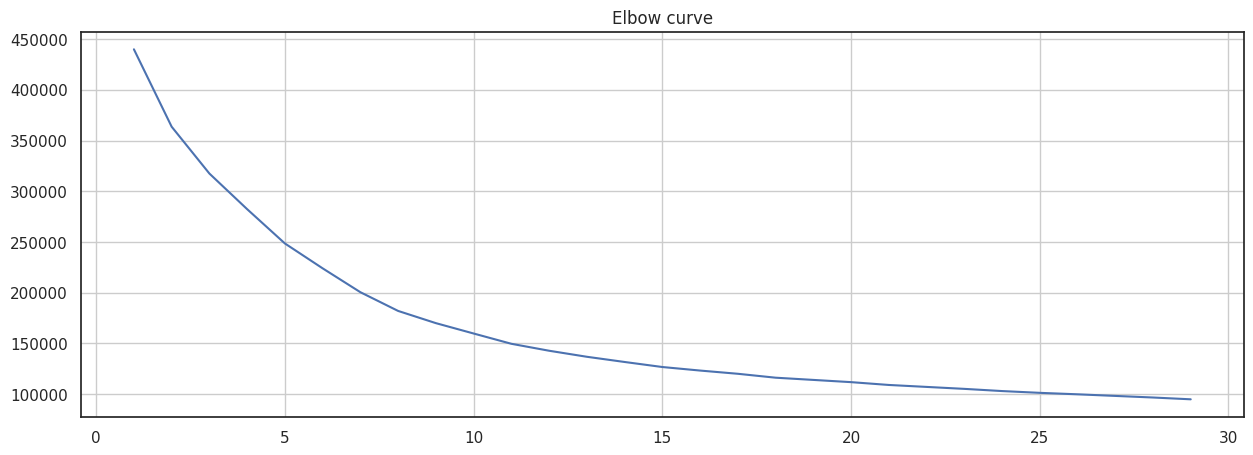

In [40]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions_pca)
plt.grid(True)
plt.title('Elbow curve')

In [41]:
kmeans_pca = KMeans(n_clusters=25)
kmeans_pca.fit(transformed_features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=25)

In [42]:
cluster_labels_pca = kmeans_pca.labels_
cluster_labels_pca.shape

(33901,)

In [43]:
cluster_df_pca = combine_cluster_labels(user_ids, cluster_labels)
cluster_df_pca

,user,cluster
0,2,27
1,4,9
2,5,27
3,7,16
4,8,0
...,...,...
33896,2102054,8
33897,2102356,16
33898,2102680,17
33899,2102983,16


In [44]:
cluster_df == cluster_df_pca

,user,cluster
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
33896,True,True
33897,True,True
33898,True,True
33899,True,True


In [45]:
# Compare element-wise and count the number of False entries
false_entries = (cluster_df != cluster_df_pca).sum()#.sum()
false_entries

user       0
cluster    0
dtype: int64

<div class="alert alert-block alert-warning">
<img style="float: left" src="https://i.postimg.cc/kXz8cFqC/005-Img-Yellow-Notes-Draft-1-20220819.png" width="60">
<b style = "font-family: Arial; font-size: 16px">Note:</b>
    
We have similar results of `cluster_df` from using user profile feature vectors and `cluster_df_pca` using PCA transformed feture vectors  
</div>



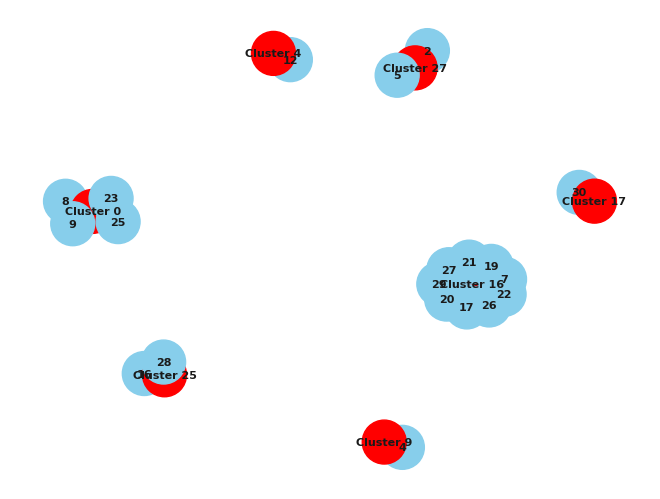

In [46]:
# Create a graph
G = nx.Graph()

# Add nodes (users) and edges (cluster connections)
for _, row in cluster_df_pca.head(20).iterrows():
    G.add_node(row['user'], node_type='user')  # Assign 'user' as node_type
    G.add_edge(row['user'], f'Cluster {row["cluster"]}')

# Extract node colors based on node type
node_colors = ['skyblue' if 'node_type' in G.nodes[node] and G.nodes[node]['node_type'] == 'user' else 'red' for node in G.nodes]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=1000, font_size=8)

# Show the plot
plt.show()

<h1><a id="Gen_1">Generate course recommendations based on the popular courses in the same cluster</a></h1>


The clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group. 

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.

In [47]:
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_user_url)[['user', 'item']] #without ratings column
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


In [48]:
## Preprocessing
### Load the data
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"

In [49]:
course_df = pd.read_csv(course_genre_url)

In [50]:
course_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


### Assign the cluster label to all test (#9402) users via merging the clustering labels Standard(`cluster_df`):

In [51]:
# test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1502801,RP0105EN,18
1,1502801,BD0131EN,18
2,1502801,BD0212EN,18
3,1502801,BD0115EN,18
4,1502801,BD0211EN,18
...,...,...,...
9397,630511,BD0121EN,0
9398,630511,SC0101EN,0
9399,630511,BD0111EN,0
9400,630511,BD0115EN,0


In [52]:
# test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled_pca = pd.merge(test_users_df, cluster_df_pca, left_on='user', right_on='user')
test_users_labelled_pca

,user,item,cluster
0,1502801,RP0105EN,18
1,1502801,BD0131EN,18
2,1502801,BD0212EN,18
3,1502801,BD0115EN,18
4,1502801,BD0211EN,18
...,...,...,...
9397,630511,BD0121EN,0
9398,630511,SC0101EN,0
9399,630511,BD0111EN,0
9400,630511,BD0115EN,0


In [53]:
# Compare element-wise and count the number of False entries
false_entries_test_user = (test_users_labelled != test_users_labelled_pca).sum()#.sum()
false_entries_test_user

user       0
item       0
cluster    0
dtype: int64

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">
    
As we have similar results in `cluster_df` and `cluster_df_pca`,  we choose one to apply the course recommendation system. 
</div>

In [54]:
#rec_merge_df = pd.merge(test_users_labelled, course_df[['COURSE_ID','TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [55]:
#rec_merge_df

Get the enrollments count for each course in each group, like the following code snippet:


In [56]:
rec_merge_df_pca = pd.merge(test_users_labelled_pca, course_df[['COURSE_ID','TITLE']], how='left', left_on='item', right_on='COURSE_ID')

In [57]:
rec_merge_df_pca

,user,item,cluster,COURSE_ID,TITLE
0,1502801,RP0105EN,18,RP0105EN,analyzing big data in r using apache spark
1,1502801,BD0131EN,18,BD0131EN,moving data into hadoop
2,1502801,BD0212EN,18,BD0212EN,spark fundamentals ii
3,1502801,BD0115EN,18,BD0115EN,mapreduce and yarn
4,1502801,BD0211EN,18,BD0211EN,spark fundamentals i
...,...,...,...,...,...
9397,630511,BD0121EN,0,BD0121EN,apache pig 101
9398,630511,SC0101EN,0,SC0101EN,scala 101
9399,630511,BD0111EN,0,BD0111EN,hadoop 101
9400,630511,BD0115EN,0,BD0115EN,mapreduce and yarn


In [58]:
courses_cluster = test_users_labelled_pca[['item', 'cluster']]
courses_cluster['count'] = [1] * len(courses_cluster)
count_enrollments_df = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
count_enrollments_df

,cluster,item,enrollments
0,0,BC0101EN,1
1,0,BD0101EN,77
2,0,BD0111EN,77
3,0,BD0115EN,33
4,0,BD0121EN,10
...,...,...,...
1554,28,TA0105,1
1555,28,TA0105EN,1
1556,28,TA0106EN,1
1557,28,TMP0105EN,1


Recommend any unseen courses based on the popular courses in his/her cluster.

In [59]:
count_enrollments_df['item'].values

array(['BC0101EN', 'BD0101EN', 'BD0111EN', ..., 'TA0106EN', 'TMP0105EN',
       'WA0101EN'], dtype=object)

In [60]:
# Determine the number of clusters dynamically
num_clusters = count_enrollments_df['cluster'].nunique()

# Group by cluster and get top 3 popular courses
popular_courses_by_cluster = count_enrollments_df.groupby('cluster') \
    .apply(lambda group: group.sort_values(by='enrollments', ascending=False).head(3)['item'].tolist()) \
    .to_dict()

# Generate recommendations using apply
recommendations_df = test_users_labelled_pca.apply(lambda row: {
    'user': row['user'],
    'cluster': row['cluster'],
    'recommended_courses': popular_courses_by_cluster.get(row['cluster'], [])[:3]
}, axis=1, result_type='expand')

# Rename the columns for clarity
recommendations_df.columns = ['user', 'cluster', 'recommended_courses']

# Display the recommendations DataFrame
recommendations_df

,user,cluster,recommended_courses
0,1502801,18,"[BD0111EN, BD0211EN, BD0101EN]"
1,1502801,18,"[BD0111EN, BD0211EN, BD0101EN]"
2,1502801,18,"[BD0111EN, BD0211EN, BD0101EN]"
3,1502801,18,"[BD0111EN, BD0211EN, BD0101EN]"
4,1502801,18,"[BD0111EN, BD0211EN, BD0101EN]"
...,...,...,...
9397,630511,0,"[BD0111EN, BD0101EN, BD0211EN]"
9398,630511,0,"[BD0111EN, BD0101EN, BD0211EN]"
9399,630511,0,"[BD0111EN, BD0101EN, BD0211EN]"
9400,630511,0,"[BD0111EN, BD0101EN, BD0211EN]"


In [61]:
# Determine the number of clusters dynamically
num_clusters = count_enrollments_df['cluster'].nunique()

# Group by cluster and get top 3 popular courses
popular_courses_by_cluster = count_enrollments_df.groupby('cluster') \
    .apply(lambda group: group.sort_values(by='enrollments', ascending=False).head(3)['item'].tolist()) \
    .to_dict()

# Generate recommendations using apply
recommendations_df = test_users_labelled_pca.apply(lambda row: pd.Series({
    'user': row['user'],
    'cluster': row['cluster'],
    'rec_1': popular_courses_by_cluster.get(row['cluster'], [])[0] if row['cluster'] in popular_courses_by_cluster else None,
    'rec_2': popular_courses_by_cluster.get(row['cluster'], [])[1] if row['cluster'] in popular_courses_by_cluster and len(popular_courses_by_cluster.get(row['cluster'], [])) > 1 else None,
    'rec_3': popular_courses_by_cluster.get(row['cluster'], [])[2] if row['cluster'] in popular_courses_by_cluster and len(popular_courses_by_cluster.get(row['cluster'], [])) > 2 else None
}), axis=1)

# Display the recommendations DataFrame
recommendations_df

,user,cluster,rec_1,rec_2,rec_3
0,1502801,18,BD0111EN,BD0211EN,BD0101EN
1,1502801,18,BD0111EN,BD0211EN,BD0101EN
2,1502801,18,BD0111EN,BD0211EN,BD0101EN
3,1502801,18,BD0111EN,BD0211EN,BD0101EN
4,1502801,18,BD0111EN,BD0211EN,BD0101EN
...,...,...,...,...,...
9397,630511,0,BD0111EN,BD0101EN,BD0211EN
9398,630511,0,BD0111EN,BD0101EN,BD0211EN
9399,630511,0,BD0111EN,BD0101EN,BD0211EN
9400,630511,0,BD0111EN,BD0101EN,BD0211EN


In [62]:
# Drop duplicate rows based on 'rec_1', 'rec_2', and 'rec_3' columns
unique_recommendations_df = recommendations_df.drop_duplicates().reset_index(drop=True)
#unique_recommendations_df = recommendations_df.drop_duplicates(subset=['rec_1']).reset_index(drop=True)

# Display the unique recommendations DataFrame
unique_recommendations_df

,user,cluster,rec_1,rec_2,rec_3
0,1502801,18,BD0111EN,BD0211EN,BD0101EN
1,1609720,10,PY0101EN,DA0101EN,DV0101EN
2,1347188,15,BC0101EN,CO0101EN,CC0101EN
3,755067,0,BD0111EN,BD0101EN,BD0211EN
4,538595,18,BD0111EN,BD0211EN,BD0101EN
...,...,...,...,...,...
995,481658,0,BD0111EN,BD0101EN,BD0211EN
996,1341273,24,CO0101EN,PY0101EN,CC0101EN
997,884271,6,BC0101EN,BD0101EN,DS0101EN
998,1868084,13,CC0101EN,CC0103EN,CC0150EN


In [63]:
# Display How many users
len(unique_recommendations_df)

1000

In [64]:
unique_recommendations_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user,1000.0,1102433.393,468510.458322,37465.0,719783.75,1078872.0,1462209.5,2087663.0
cluster,1000.0,13.657,8.417137,0.0,6.00,16.0,21.0,28.0


In [65]:
unique_recommendations_df[unique_recommendations_df['user'] == 1078030]

,user,cluster,rec_1,rec_2,rec_3
102,1078030,1,PY0101EN,DA0101EN,DV0101EN


In [66]:
unique_recommendations_df[unique_recommendations_df['user'] == 733707]

,user,cluster,rec_1,rec_2,rec_3
298,733707,9,BD0111EN,PY0101EN,BD0211EN


In [67]:
unique_recommendations_df[unique_recommendations_df['user'] == 674939]

,user,cluster,rec_1,rec_2,rec_3
151,674939,28,BD0111EN,BD0115EN,BD0211EN


In [68]:
unique_recommendations_df[unique_recommendations_df['user'] == 2057052]

,user,cluster,rec_1,rec_2,rec_3
221,2057052,16,DS0101EN,BD0101EN,PY0101EN


In [69]:
# Merge for rec_1
recom_merge_df_pca = pd.merge(unique_recommendations_df, rec_merge_df_pca[['COURSE_ID', 'TITLE']], how='left', left_on='rec_1', right_on='COURSE_ID')
recom_merge_df_pca = recom_merge_df_pca.rename(columns={'TITLE': 'title_1'})

In [70]:
recom_merge_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID,title_1
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
1,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
2,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
3,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
4,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
...,...,...,...,...,...,...,...
377793,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101
377794,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101
377795,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101
377796,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101


In [71]:
recom_merge_df_pca = recom_merge_df_pca.drop_duplicates().reset_index(drop=True)
recom_merge_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID,title_1
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
1,1609720,10,PY0101EN,DA0101EN,DV0101EN,PY0101EN,python for data science
2,1347188,15,BC0101EN,CO0101EN,CC0101EN,BC0101EN,blockchain essentials
3,755067,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101
4,538595,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101
...,...,...,...,...,...,...,...
995,481658,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101
996,1341273,24,CO0101EN,PY0101EN,CC0101EN,CO0101EN,docker essentials a developer introduction
997,884271,6,BC0101EN,BD0101EN,DS0101EN,BC0101EN,blockchain essentials
998,1868084,13,CC0101EN,CC0103EN,CC0150EN,CC0101EN,introduction to cloud


In [72]:
# Merge for rec_2
recom_merge_df_pca = pd.merge(recom_merge_df_pca, rec_merge_df_pca[['COURSE_ID', 'TITLE']], how='left', left_on='rec_2', right_on='COURSE_ID')
recom_merge_df_pca = recom_merge_df_pca.rename(columns={'TITLE': 'title_2'})

In [73]:
recom_merge_df_pca = recom_merge_df_pca.drop_duplicates().reset_index(drop=True)
recom_merge_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID_x,title_1,COURSE_ID_y,title_2
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i
1,1609720,10,PY0101EN,DA0101EN,DV0101EN,PY0101EN,python for data science,DA0101EN,data analysis with python
2,1347188,15,BC0101EN,CO0101EN,CC0101EN,BC0101EN,blockchain essentials,CO0101EN,docker essentials a developer introduction
3,755067,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101
4,538595,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i
...,...,...,...,...,...,...,...,...,...
995,481658,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101
996,1341273,24,CO0101EN,PY0101EN,CC0101EN,CO0101EN,docker essentials a developer introduction,PY0101EN,python for data science
997,884271,6,BC0101EN,BD0101EN,DS0101EN,BC0101EN,blockchain essentials,BD0101EN,big data 101
998,1868084,13,CC0101EN,CC0103EN,CC0150EN,CC0101EN,introduction to cloud,CC0103EN,ibm cloud essentials v3


In [74]:
recom_merge_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID_x,title_1,COURSE_ID_y,title_2
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i
1,1609720,10,PY0101EN,DA0101EN,DV0101EN,PY0101EN,python for data science,DA0101EN,data analysis with python
2,1347188,15,BC0101EN,CO0101EN,CC0101EN,BC0101EN,blockchain essentials,CO0101EN,docker essentials a developer introduction
3,755067,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101
4,538595,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i
...,...,...,...,...,...,...,...,...,...
995,481658,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101
996,1341273,24,CO0101EN,PY0101EN,CC0101EN,CO0101EN,docker essentials a developer introduction,PY0101EN,python for data science
997,884271,6,BC0101EN,BD0101EN,DS0101EN,BC0101EN,blockchain essentials,BD0101EN,big data 101
998,1868084,13,CC0101EN,CC0103EN,CC0150EN,CC0101EN,introduction to cloud,CC0103EN,ibm cloud essentials v3


In [75]:
# Merge for rec_3
recom_merge_df_pca = pd.merge(recom_merge_df_pca, rec_merge_df_pca[['COURSE_ID', 'TITLE']], how='left', left_on='rec_3', right_on='COURSE_ID')
recom_merge_df_pca = recom_merge_df_pca.rename(columns={'TITLE': 'title_3'})

# Display the merged DataFrame
recom_merge_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID_x,title_1,COURSE_ID_y,title_2,COURSE_ID,title_3
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
1,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
2,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
3,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
4,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
...,...,...,...,...,...,...,...,...,...,...,...
376013,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i
376014,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i
376015,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i
376016,630511,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i


In [76]:
# Drop duplicate rows based on 'rec_1', 'rec_2', and 'rec_3' columns
unique_recommendations_df_pca = recom_merge_df_pca.drop_duplicates().reset_index(drop=True)
#unique_recommendations_df = recommendations_df.drop_duplicates(subset=['rec_1']).reset_index(drop=True)

# Display the unique recommendations DataFrame
unique_recommendations_df_pca

,user,cluster,rec_1,rec_2,rec_3,COURSE_ID_x,title_1,COURSE_ID_y,title_2,COURSE_ID,title_3
0,1502801,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
1,1609720,10,PY0101EN,DA0101EN,DV0101EN,PY0101EN,python for data science,DA0101EN,data analysis with python,DV0101EN,data visualization with python
2,1347188,15,BC0101EN,CO0101EN,CC0101EN,BC0101EN,blockchain essentials,CO0101EN,docker essentials a developer introduction,CC0101EN,introduction to cloud
3,755067,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i
4,538595,18,BD0111EN,BD0211EN,BD0101EN,BD0111EN,hadoop 101,BD0211EN,spark fundamentals i,BD0101EN,big data 101
...,...,...,...,...,...,...,...,...,...,...,...
995,481658,0,BD0111EN,BD0101EN,BD0211EN,BD0111EN,hadoop 101,BD0101EN,big data 101,BD0211EN,spark fundamentals i
996,1341273,24,CO0101EN,PY0101EN,CC0101EN,CO0101EN,docker essentials a developer introduction,PY0101EN,python for data science,CC0101EN,introduction to cloud
997,884271,6,BC0101EN,BD0101EN,DS0101EN,BC0101EN,blockchain essentials,BD0101EN,big data 101,DS0101EN,introduction to data science
998,1868084,13,CC0101EN,CC0103EN,CC0150EN,CC0101EN,introduction to cloud,CC0103EN,ibm cloud essentials v3,CC0150EN,building cloud native and multicloud applications


In [77]:
# Drop unnecessary columns
unique_recommendations_df_pca = unique_recommendations_df_pca.drop(['COURSE_ID_x', 'COURSE_ID_y', 'COURSE_ID'], axis=1)

In [78]:
unique_recommendations_df_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
user,1000.0,1102433.393,468510.458322,37465.0,719783.75,1078872.0,1462209.5,2087663.0
cluster,1000.0,13.657,8.417137,0.0,6.00,16.0,21.0,28.0


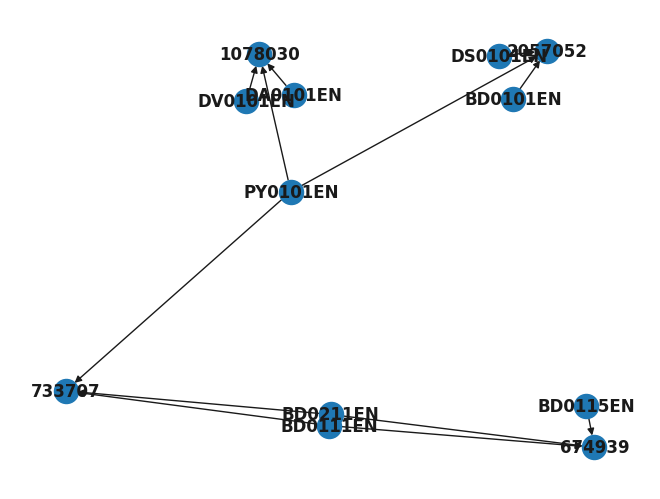

In [79]:
# Create a directed graph
G = nx.DiGraph()

# Add edges based on 'rec_1', 'rec_2', and 'rec_3' columns for specific users
target_users = [1078030, 733707, 674939,2057052]
for _, row in unique_recommendations_df_pca[unique_recommendations_df_pca['user'].isin(target_users)].iterrows():
    G.add_edge(row['rec_1'], row['user'])
    G.add_edge(row['rec_2'], row['user'])
    G.add_edge(row['rec_3'], row['user'])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Show the plot
plt.show()

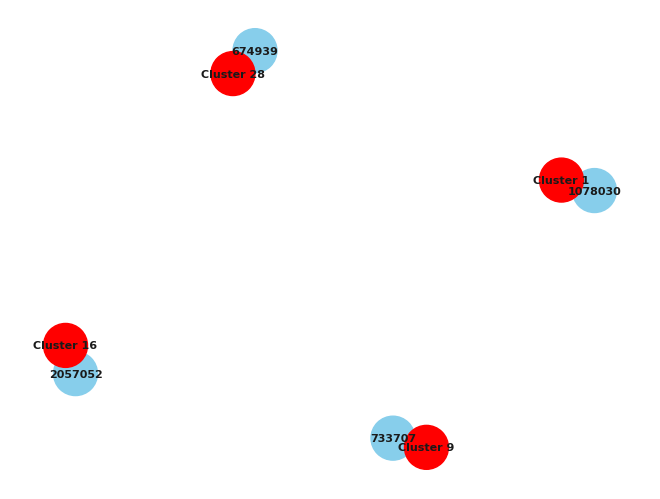

In [80]:
# Create a graph
G = nx.Graph()

# Add nodes (users) and edges (cluster connections) for target users
for _, row in unique_recommendations_df_pca[unique_recommendations_df_pca['user'].isin(target_users)].iterrows():
    G.add_node(row['user'], node_type='user')  # Assign 'user' as node_type
    G.add_edge(row['user'], f'Cluster {row["cluster"]}')

# Extract node colors based on node type
node_colors = ['skyblue' if 'node_type' in G.nodes[node] and G.nodes[node]['node_type'] == 'user' else 'red' for node in G.nodes]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=1000, font_size=8)

# Show the plot
plt.show()

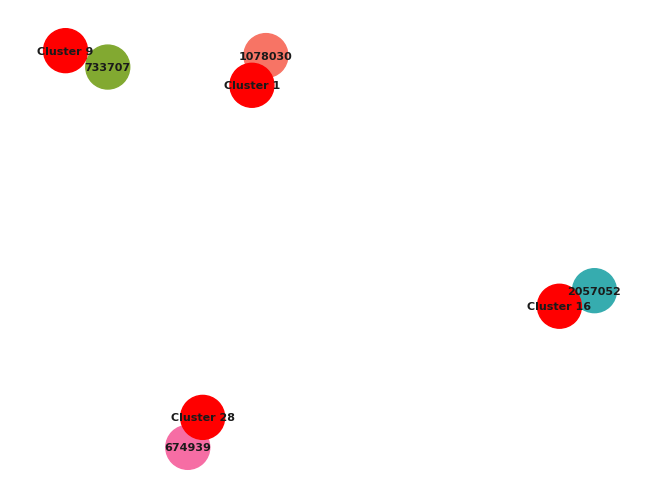

In [81]:
# Create a graph
G = nx.Graph()

# Extract unique clusters
unique_clusters = sorted(set(unique_recommendations_df_pca['cluster']))

# Assign colors to clusters
cluster_colors = dict(zip(unique_clusters, sns.color_palette('husl', n_colors=len(unique_clusters))))

# Add nodes (users) and edges (cluster connections) for target users
for _, row in unique_recommendations_df_pca.iterrows():
    user = row['user']
    if user in target_users:
        G.add_node(user, node_type='user', cluster=row['cluster'])  # Assign 'user' and cluster
        G.add_edge(user, f'Cluster {row["cluster"]}')

# Extract node colors based on node type, cluster, and target users
node_colors = [cluster_colors[G.nodes[node]['cluster']] if 'cluster' in G.nodes[node] else 'red' for node in G.nodes]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=1000, font_size=8)

# Show the plot
plt.show()

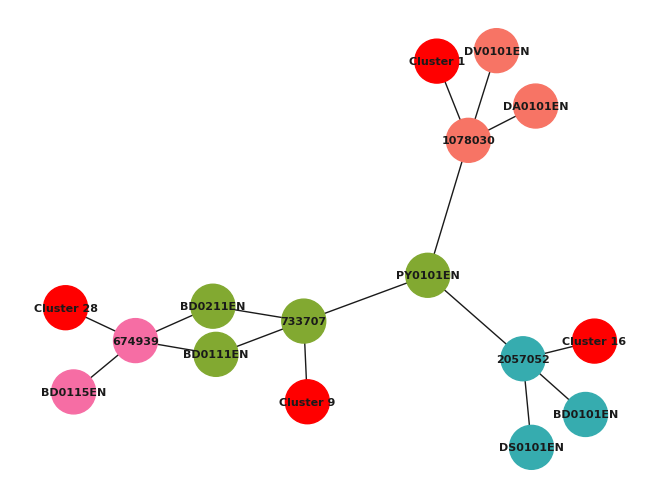

In [82]:
# Create a graph
G = nx.Graph()

# Extract unique clusters
unique_clusters = sorted(set(unique_recommendations_df_pca['cluster']))

# Assign colors to clusters
cluster_colors = dict(zip(unique_clusters, sns.color_palette('husl', n_colors=len(unique_clusters))))

# Add nodes (users, rec_1, rec_2, rec_3) and edges (cluster connections, rec connections) for target users
for _, row in unique_recommendations_df_pca.iterrows():
    user = row['user']
    rec_1 = row['rec_1']
    rec_2 = row['rec_2']
    rec_3 = row['rec_3']
    
    if user in target_users:
        G.add_node(user, node_type='user', cluster=row['cluster'])  # Assign 'user' and cluster
        G.add_edge(user, f'Cluster {row["cluster"]}')
        
        G.add_node(rec_1, node_type='rec', cluster=row['cluster'])  # Assign 'rec' and cluster
        G.add_node(rec_2, node_type='rec', cluster=row['cluster'])  # Assign 'rec' and cluster
        G.add_node(rec_3, node_type='rec', cluster=row['cluster'])  # Assign 'rec' and cluster
        
        G.add_edge(user, rec_1, connection_type='rec')
        G.add_edge(user, rec_2, connection_type='rec')
        G.add_edge(user, rec_3, connection_type='rec')

# Extract node colors based on node type, cluster, and target users
node_colors = [cluster_colors[G.nodes[node]['cluster']] if 'cluster' in G.nodes[node] else 'red' for node in G.nodes]

# Plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=1000, font_size=8)

# Show the plot
plt.show()

In [83]:
unique_recommendations_df_pca[unique_recommendations_df_pca['user'].isin(target_users)]

,user,cluster,rec_1,rec_2,rec_3,title_1,title_2,title_3
102,1078030,1,PY0101EN,DA0101EN,DV0101EN,python for data science,data analysis with python,data visualization with python
151,674939,28,BD0111EN,BD0115EN,BD0211EN,hadoop 101,mapreduce and yarn,spark fundamentals i
221,2057052,16,DS0101EN,BD0101EN,PY0101EN,introduction to data science,big data 101,python for data science
298,733707,9,BD0111EN,PY0101EN,BD0211EN,hadoop 101,python for data science,spark fundamentals i


In [84]:
from IPython.display import display, HTML
# Link HTML files for pages
output_file_01 = "https://www.kaggle.com/wahyuardhitama/task003-p001-ml-dl-rec-sys-course-20231025"
output_file_03 = "https://www.kaggle.com/wahyuardhitama/task003-p003-ml-dl-rec-sys-course-20231101"

# Display links to the saved HTML files
display(HTML(f"<p style='font-size: 18px;'>Go to <a href='{output_file_01}' target='_blank' style='font-size: 18px;'>P01 </a>or <a href='{output_file_03}' target='_blank' style='font-size: 18px;'>P03 </a></p>"))

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
</b>
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The profile clustering results
    <li>Identify groups of users with similar preferences within the same cluster.
    <li>Users within the same cluster typically share common characteristics or preferences.
    <li>The system focuses on clusters, reducing the complexity from considering every user .
    <li>Recommendations remain relevant from changes.    
</ol>
